# CIFAR-100: DropPath vs DropBlock (Aynı Model İçinde Karşılaştırma)

Bu notebook:
- Aynı backbone (ResNet-benzeri) ✅  
- Aynı eğitim ayarları (seed/optimizer/scheduler/augment) ✅  
- Sadece regularization modu değişiyor:  
  - `none` (baseline)  
  - `droppath`  
  - `dropblock`  
  - `dropblock+droppath`  

> Not: CIFAR-100 download için internet gerekir (torchvision otomatik indirir).  
> Notebook'u çalıştırmadan önce GPU önerilir.  


In [10]:
# === 0) Kurulum / Imports ===
import os, math, random, time
from dataclasses import dataclass
from typing import Optional, Literal, Dict, Tuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as T

from torch.utils.data import DataLoader


In [11]:
# === 1) Reprodüksiyon / Seed ===
def seed_everything(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = False
    torch.backends.cudnn.benchmark = True

seed_everything(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

## 2) Bizim Modellerimiz 

Aşağıdaki iki sınıf:
- `DropPath`
- `DropBlock2D_Scheduled`

⚠️ DropBlock tarafında, pool/padding kaynaklı shape kayması riskine karşı `block_mask` üretildikten sonra **(H,W)**'ye crop uygulanıyor.
Bu, matematiği bozmaz; sadece maskeyi girişle aynı boyuta getirir.


In [12]:

import torch
import torch.nn as nn

class DropPath(nn.Module):
    def __init__(
        self,
        max_drop: float = 0.0,
        layer_idx: int | None = None,
        num_layers: int | None = None,
        warmup_steps: int = 0,
        batchwise: bool = True,
        store_mask: bool = True,
    ):
        super().__init__()
        self.max_drop = float(max_drop)
        self.layer_idx = layer_idx
        self.num_layers = num_layers
        self.warmup_steps = int(warmup_steps)
        self.batchwise = bool(batchwise)
        self.store_mask = bool(store_mask)

        self.register_buffer("step", torch.zeros((), dtype=torch.long))
        self.last_mask = None

    def layer_scaled_drop(self) -> float:
        if self.layer_idx is None or self.num_layers is None or self.num_layers <= 1:
            return self.max_drop
        frac = float(self.layer_idx) / float(self.num_layers - 1)
        return self.max_drop * frac

    def warmup_drop_prob(self, drop: float) -> float:
        if self.warmup_steps <= 0:
            return drop
        s = int(self.step.item())
        t = min(max(s / float(self.warmup_steps), 0.0), 1.0)
        return drop * t

    def current_drop_prob(self) -> float:
        d = self.layer_scaled_drop()
        d = self.warmup_drop_prob(d)
        if d < 0.0:
            d = 0.0
        if d >= 1.0:
            d = 0.999
        return d

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.training:
            self.step += 1

        drop_prob = self.current_drop_prob()

        if drop_prob <= 0.0 or (not self.training):
            if self.store_mask:
                self.last_mask = None
            return x

        keep_prob = 1.0 - drop_prob

        if self.batchwise:
            mask_shape = (x.shape[0],) + (1,) * (x.ndim - 1)
        else:
            mask_shape = x.shape

        mask = torch.empty(mask_shape, device=x.device, dtype=x.dtype).bernoulli_(keep_prob)

        if self.store_mask:
            self.last_mask = mask.detach()

        return x * mask / keep_prob


In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DropBlock2D_Scheduled(nn.Module):
    def __init__(self, max_drop_prob=0.1, block_size=7, total_steps=10_000):
        super().__init__()
        self.max_drop_prob = float(max_drop_prob)
        self.block_size = int(block_size)
        self.total_steps = int(total_steps)
        self.register_buffer("step", torch.zeros((), dtype=torch.long))

    def _current_drop_prob(self):
        s = int(self.step.item())
        t = min(max(s / max(1, self.total_steps), 0.0), 1.0)
        return self.max_drop_prob * t

    def forward(self, x):
        if self.training:
            self.step += 1

        drop_prob = self._current_drop_prob()

        if (not self.training) or drop_prob <= 0.0:
            return x

        if x.dim() != 4:
            raise ValueError(f"DropBlock 4D tensor bekler (N,C,H,W). Geldi: {x.shape}")

        n, c, h, w = x.shape

        bs = min(self.block_size, h, w)
        if bs < 1:
            return x

        valid_h = h - bs + 1
        valid_w = w - bs + 1
        block_area = bs * bs

        gamma = drop_prob * (h * w) / (block_area * valid_h * valid_w)

        center_mask = (torch.rand((n, c, valid_h, valid_w), device=x.device) < gamma).float()

        pad_h = (bs - 1) // 2
        pad_w = (bs - 1) // 2
        center_mask = F.pad(center_mask, (pad_w, pad_w, pad_h, pad_h))

        block_mask = F.max_pool2d(center_mask, kernel_size=bs, stride=1, padding=bs // 2)

        # shape-safe crop (pool/padding yüzünden 1-2 piksel oynama olursa sabitle)
        block_mask = block_mask[:, :, :h, :w]

        mask = 1.0 - block_mask
        keep_prob = mask.mean().clamp(min=1e-6)
        return x * mask / keep_prob


## 3) Aynı Model: CIFAR-100 için ResNet-Benzeri Backbone

- 3 stage (64/128/256)  
- Residual block içinde:  
  - `DropBlock` opsiyonel (aktivasyondan sonra)  
  - `DropPath` opsiyonel (residual branch çıkışında, shortcut eklenmeden hemen önce)  


In [14]:
# === 3.1) Model Bileşenleri ===
class ConvBNAct(nn.Module):
    def __init__(self, cin, cout, k=3, s=1, p=1, act="relu"):
        super().__init__()
        self.conv = nn.Conv2d(cin, cout, k, stride=s, padding=p, bias=False)
        self.bn = nn.BatchNorm2d(cout)
        if act == "relu":
            self.act = nn.ReLU(inplace=True)
        elif act == "silu":
            self.act = nn.SiLU(inplace=True)
        else:
            raise ValueError("act must be 'relu' or 'silu'")

    def forward(self, x):
        return self.act(self.bn(self.conv(x)))

class ResidualBlock(nn.Module):
    def __init__(
        self,
        cin: int,
        cout: int,
        stride: int = 1,
        act: str = "relu",
        dropblock: Optional[nn.Module] = None,
        droppath: Optional[nn.Module] = None,
    ):
        super().__init__()
        self.conv1 = ConvBNAct(cin, cout, k=3, s=stride, p=1, act=act)
        self.conv2 = nn.Sequential(
            nn.Conv2d(cout, cout, 3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(cout),
        )
        self.act = nn.ReLU(inplace=True) if act == "relu" else nn.SiLU(inplace=True)

        self.dropblock = dropblock
        self.droppath = droppath

        if cin != cout or stride != 1:
            self.shortcut = nn.Sequential(
                nn.Conv2d(cin, cout, 1, stride=stride, padding=0, bias=False),
                nn.BatchNorm2d(cout),
            )
        else:
            self.shortcut = nn.Identity()

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)

        # DropBlock: feature map üstünde (BN sonrası, Act öncesi veya sonrası yapılabilir)
        # Pratikte: act sonrası daha yaygın. Biz burada act'ten sonra uyguluyoruz.
        out = self.act(out)
        if self.dropblock is not None:
            out = self.dropblock(out)

        # DropPath: residual branch'i (out) tamamen kapatabilen mekanizma
        if self.droppath is not None:
            out = self.droppath(out)

        return out + self.shortcut(x)

class CIFARResNet(nn.Module):
    def __init__(
        self,
        num_classes: int = 100,
        act: str = "relu",
        mode: Literal["none","droppath","dropblock","dropblock+droppath"] = "none",
        dropblock_max: float = 0.1,
        dropblock_size: int = 7,
        dropblock_steps: int = 10_000,
        droppath_max: float = 0.1,
        droppath_warmup: int = 2_000,
    ):
        super().__init__()
        self.mode = mode

        self.stem = nn.Sequential(
            ConvBNAct(3, 64, k=3, s=1, p=1, act=act),
            ConvBNAct(64, 64, k=3, s=1, p=1, act=act),
        )

        # toplam block sayısı (layer schedule için)
        blocks_per_stage = [3, 3, 3]
        total_blocks = sum(blocks_per_stage)

        def make_stage(cin, cout, nblocks, stride, start_idx):
            layers = []
            for i in range(nblocks):
                block_stride = stride if i == 0 else 1
                layer_idx = start_idx + i

                use_db = (mode in ["dropblock", "dropblock+droppath"])
                use_dp = (mode in ["droppath", "dropblock+droppath"])

                db = DropBlock2D_Scheduled(dropblock_max, dropblock_size, dropblock_steps) if use_db else None
                dp = DropPath(
                    max_drop=droppath_max,
                    layer_idx=layer_idx,
                    num_layers=total_blocks,
                    warmup_steps=droppath_warmup,
                    batchwise=True,
                    store_mask=False,
                ) if use_dp else None

                layers.append(ResidualBlock(cin if i==0 else cout, cout, block_stride, act=act, dropblock=db, droppath=dp))
            return nn.Sequential(*layers)

        idx = 0
        self.stage1 = make_stage(64, 64, 3, stride=1, start_idx=idx); idx += 3
        self.stage2 = make_stage(64, 128, 3, stride=2, start_idx=idx); idx += 3
        self.stage3 = make_stage(128, 256, 3, stride=2, start_idx=idx); idx += 3

        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.stem(x)
        x = self.stage1(x)
        x = self.stage2(x)
        x = self.stage3(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)


## 4) CIFAR-100 DataLoaders

Augment: random crop + horizontal flip + normalize  


In [15]:
# === 4) Data ===
@dataclass
class DataCfg:
    root: str = "./data"
    batch_size: int = 128
    num_workers: int = 2

data_cfg = DataCfg()

mean = (0.5071, 0.4867, 0.4408)
std  = (0.2675, 0.2565, 0.2761)

train_tf = T.Compose([
    T.RandomCrop(32, padding=4),
    T.RandomHorizontalFlip(),
    T.ToTensor(),
    T.Normalize(mean, std),
])

test_tf = T.Compose([
    T.ToTensor(),
    T.Normalize(mean, std),
])

train_ds = torchvision.datasets.CIFAR100(root=data_cfg.root, train=True, download=True, transform=train_tf)
test_ds  = torchvision.datasets.CIFAR100(root=data_cfg.root, train=False, download=True, transform=test_tf)

train_loader = DataLoader(train_ds, batch_size=data_cfg.batch_size, shuffle=True, num_workers=data_cfg.num_workers, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=data_cfg.batch_size, shuffle=False, num_workers=data_cfg.num_workers, pin_memory=True)

len(train_ds), len(test_ds)


Files already downloaded and verified
Files already downloaded and verified


(50000, 10000)

## 5) Train / Eval Loop + Metrics


In [ ]:
# === 5) Train/Eval ===
@torch.no_grad()
def accuracy_top1(logits, y):
    pred = logits.argmax(dim=1)
    return (pred == y).float().mean().item()

def train_one_epoch(model, loader, optimizer, scaler=None):
    model.train()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        optimizer.zero_grad(set_to_none=True)

        if scaler is None:
            logits = model(x)
            loss = F.cross_entropy(logits, y)
            loss.backward()
            optimizer.step()
        else:
            with torch.cuda.amp.autocast():
                logits = model(x)
                loss = F.cross_entropy(logits, y)
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits.detach(), y) * bs
        n += bs
    return total_loss / n, total_acc / n

@torch.no_grad()
def eval_one_epoch(model, loader):
    model.eval()
    total_loss, total_acc, n = 0.0, 0.0, 0
    for x, y in loader:
        x, y = x.to(device, non_blocking=True), y.to(device, non_blocking=True)
        logits = model(x)
        loss = F.cross_entropy(logits, y)

        bs = x.size(0)
        total_loss += loss.item() * bs
        total_acc  += accuracy_top1(logits, y) * bs
        n += bs
    return total_loss / n, total_acc / n

## 6) Deney Konfigürasyonu ve Karşılaştırma

Burada 4 koşulu art arda eğitiyoruz:
1) Baseline (`none`)  
2) `droppath`  
3) `dropblock`  
4) `dropblock+droppath`  

Çıktı: epoch bazlı loss/acc tabloları + plot.  


In [17]:
# === 6) Experiment Runner ===
import pandas as pd
import matplotlib.pyplot as plt

@dataclass
class TrainCfg:
    epochs: int = 12
    lr: float = 0.1
    weight_decay: float = 5e-4
    momentum: float = 0.9
    use_amp: bool = True

train_cfg = TrainCfg(epochs=15)

def run_experiment(mode: str, seed: int = 42) -> pd.DataFrame:
    seed_everything(seed)
    model = CIFARResNet(
        num_classes=100,
        act="relu",
        mode=mode,
        dropblock_max=0.1,
        dropblock_size=7,
        dropblock_steps=10_000,
        droppath_max=0.1,
        droppath_warmup=2_000,
    ).to(device)

    optimizer = optim.SGD(model.parameters(), lr=train_cfg.lr, momentum=train_cfg.momentum, weight_decay=train_cfg.weight_decay, nesterov=True)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=train_cfg.epochs)

    scaler = torch.cuda.amp.GradScaler() if (train_cfg.use_amp and device == "cuda") else None

    rows = []
    for epoch in range(1, train_cfg.epochs + 1):
        t0 = time.time()
        tr_loss, tr_acc = train_one_epoch(model, train_loader, optimizer, scaler)
        te_loss, te_acc = eval_one_epoch(model, test_loader)
        scheduler.step()

        rows.append({
            "mode": mode,
            "epoch": epoch,
            "train_loss": tr_loss,
            "train_acc": tr_acc,
            "test_loss": te_loss,
            "test_acc": te_acc,
            "lr": scheduler.get_last_lr()[0],
            "sec": time.time() - t0,
        })
        print(f"[{mode}] epoch {epoch:02d}/{train_cfg.epochs} | tr_loss={tr_loss:.4f} tr_acc={tr_acc:.4f} | te_loss={te_loss:.4f} te_acc={te_acc:.4f} | lr={rows[-1]['lr']:.5f}")
    return pd.DataFrame(rows)

modes = ["none", "droppath", "dropblock", "dropblock+droppath"]


In [18]:
all_df = []
for m in modes:
    df = run_experiment(m, seed=42)
    all_df.append(df)

results = pd.concat(all_df, ignore_index=True)
results.head()


C:\Users\hdgn5\AppData\Local\Temp\ipykernel_4292\522754047.py:31: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() if (train_cfg.use_amp and device == "cuda") else None
C:\Users\hdgn5\AppData\Local\Temp\ipykernel_4292\490807882.py:20: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


[none] epoch 01/15 | tr_loss=3.9540 tr_acc=0.0932 | te_loss=3.6969 te_acc=0.1357 | lr=0.09891
[none] epoch 02/15 | tr_loss=3.2728 tr_acc=0.1991 | te_loss=3.1125 te_acc=0.2338 | lr=0.09568
[none] epoch 03/15 | tr_loss=2.7099 tr_acc=0.3033 | te_loss=2.6654 te_acc=0.3133 | lr=0.09045
[none] epoch 04/15 | tr_loss=2.2914 tr_acc=0.3927 | te_loss=2.4240 te_acc=0.3809 | lr=0.08346
[none] epoch 05/15 | tr_loss=1.9952 tr_acc=0.4565 | te_loss=2.1612 te_acc=0.4286 | lr=0.07500
[none] epoch 06/15 | tr_loss=1.7808 tr_acc=0.5069 | te_loss=2.3025 te_acc=0.4162 | lr=0.06545
[none] epoch 07/15 | tr_loss=1.6082 tr_acc=0.5499 | te_loss=1.7854 te_acc=0.5124 | lr=0.05523
[none] epoch 08/15 | tr_loss=1.4518 tr_acc=0.5884 | te_loss=1.7406 te_acc=0.5364 | lr=0.04477
[none] epoch 09/15 | tr_loss=1.3047 tr_acc=0.6241 | te_loss=1.5698 te_acc=0.5693 | lr=0.03455
[none] epoch 10/15 | tr_loss=1.1521 tr_acc=0.6656 | te_loss=1.4277 te_acc=0.5986 | lr=0.02500
[none] epoch 11/15 | tr_loss=1.0040 tr_acc=0.7052 | te_loss=

,mode,epoch,train_loss,train_acc,test_loss,test_acc,lr,sec
0,none,1,3.953969,0.09320,3.696926,0.1357,0.098907,41.784766
1,none,2,3.272761,0.19910,3.112511,0.2338,0.095677,41.764533
2,none,3,2.709893,0.30330,2.665443,0.3133,0.090451,42.036178
3,none,4,2.291427,0.39268,2.423990,0.3809,0.083457,41.534835
4,none,5,1.995221,0.45646,2.161169,0.4286,0.075000,42.146811


In [19]:
# === 6.2) Tablo: Son Epoch Özeti ===
summary = (results.sort_values(['mode','epoch'])
           .groupby('mode', as_index=False)
           .tail(1)
           .sort_values('test_acc', ascending=False))
summary

,mode,epoch,train_loss,train_acc,test_loss,test_acc,lr,sec
44,dropblock,15,0.668906,0.80376,1.003533,0.7112,0.0,53.884816
14,none,15,0.534354,0.84972,1.038333,0.7066,0.0,43.993701
59,dropblock+droppath,15,0.877385,0.75124,1.062680,0.6938,0.0,56.145182
29,droppath,15,0.791385,0.77640,1.101871,0.6880,0.0,46.970857


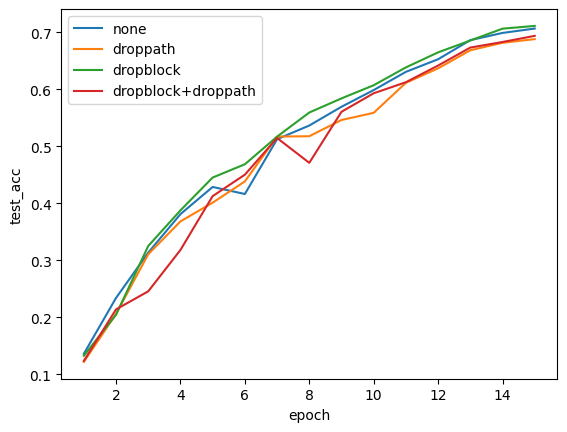

In [20]:
# === 6.3) Plot: Test Acc ===
plt.figure()
for m in modes:
    sub = results[results['mode'] == m]
    plt.plot(sub['epoch'], sub['test_acc'], label=m)
plt.xlabel("epoch")
plt.ylabel("test_acc")
plt.legend()
plt.show()

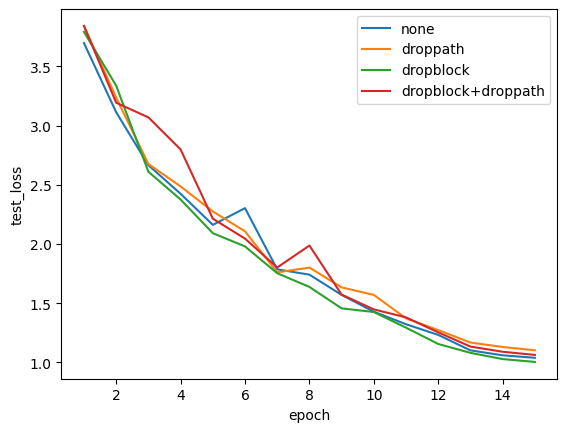

In [21]:
# === 6.4) Plot: Test Loss ===
plt.figure()
for m in modes:
    sub = results[results['mode'] == m]
    plt.plot(sub['epoch'], sub['test_loss'], label=m)
plt.xlabel("epoch")
plt.ylabel("test_loss")
plt.legend()
plt.show()

# 📊 Training Log Açıklaması (Jupyter)

Eğitim sırasında her epoch sonunda şu formatta bir çıktı alıyoruz: **[dropblock] epoch 10/15 | tr_loss=1.1980 tr_acc=0.6540 | te_loss=1.4251 te_acc=0.6071 | lr=0.02500**



Bu satırın her parçası aşağıdaki anlamlara gelir:

---

## 1️⃣ `[dropblock]`

Modelin hangi versiyonu çalışıyor?

- `none` → Regularization yok (baseline)
- `droppath` → DropPath aktif
- `dropblock` → DropBlock aktif
- `dropblock+droppath` → İkisi birlikte

Bu etiket, karşılaştırma yaptığımız modeli belirtir.

---

## 2️⃣ `epoch 10/15`

- Eğitim toplam **15 epoch**
- Şu an **10. epoch** çalışıyor

Epoch = Dataset’in tamamının bir kez modellen geçmesi.

---

## 3️⃣ `tr_loss=1.1980`

Training Loss

- Cross-entropy loss değeri
- Modelin training verisinde ne kadar hata yaptığını gösterir
- Küçük olması iyidir

Genelde epoch ilerledikçe azalır.

---

## 4️⃣ `tr_acc=0.6540`

Training Accuracy

- Training set üzerindeki doğruluk
- %65.40 doğruluk demek
- Genelde epoch ilerledikçe artar

---

## 5️⃣ `te_loss=1.4251`

Test Loss

- Modelin görmediği verideki hata
- Overfitting’i anlamak için önemlidir

Eğer:
- Train loss ↓
- Test loss ↑

ise overfitting başlamıştır.

---

## 6️⃣ `te_acc=0.6071`

Test Accuracy

- Modelin gerçek genelleme performansı
- Asıl karşılaştırma metriğimiz budur

Regularization tekniklerini genelde bu değerle kıyaslarız.

---

## 7️⃣ `lr=0.02500`

Learning Rate

CosineAnnealingLR kullandığımız için:
- Başta yüksek
- Sonlara doğru azalır
- Son epoch’ta ≈ 0 olur

LR düşerken model daha stabil fine-tune yapar.

---

# 🔍 Overfitting Nasıl Okunur?

Örnek (baseline final epoch):
```text
tr_acc = 0.8497
te_acc = 0.7066
```

Gap = 0.8497 - 0.7066 = 0.1431

Bu fark ne kadar büyükse:
→ Model training verisine aşırı uyum sağlamış demektir.

---

# 🧠 Regularization Etkisini Log Üzerinden Anlama

## Eğer:

- Train acc düşüyor
- Test acc artıyorsa

→ Regularization işe yarıyor.

## Eğer:

- Train acc çok düşüyor
- Test acc da düşük kalıyorsa

→ Aşırı regularization (underfitting)

---

# 📌 Bu Çıktılardan Genel Yorum

| Model | Final Test Acc |
|-------|----------------|
| none | 0.7066 |
| droppath | 0.6880 |
| dropblock | 0.7112 |
| dropblock+droppath | 0.6938 |

- DropBlock en iyi sonucu verdi.
- DropPath overfitting’i azalttı ama underfit'e kaydı.
- İkisini birlikte kullanmak bu epoch sayısında fazla agresif geldi.

---

# ⚠️ AMP FutureWarning Açıklaması

Şu uyarılar hata değildir:
```text 
FutureWarning: torch.cuda.amp.GradScaler deprecated
FutureWarning: torch.cuda.amp.autocast deprecated
```

Yeni kullanım:

```python
scaler = torch.amp.GradScaler("cuda")

with torch.amp.autocast("cuda"):
```


